In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
torch.manual_seed(42)
import matplotlib.pyplot as plt
from PIL import Image
import skimage
np.random.seed(42)
torch.manual_seed(42)

In [4]:

class relu_mlp(nn.Module):
  def __init__(self, neurons, h_layers):
    super(relu_mlp, self).__init__()
    self.neurons = neurons
    self.h_layers = h_layers

    self.layers = nn.ModuleList()
    self.layers.append(nn.Linear(1,neurons))
    for i in range (h_layers-1):
      self.layers.append(nn.Linear(neurons,neurons))
    self.layers.append(nn.Linear(neurons, 1))
  
  def forward (self,x):
    for layer in self.layers[:-1]:
      x = F.relu(layer(x))
    x = self.layers[-1](x)
    return x

In [5]:
class siren_mlp(nn.Module):
  def __init__(self, neurons, h_layers, omega):
    super(siren_mlp, self).__init__()
    self.neurons = neurons
    self.h_layers = h_layers
    self.omega = omega

    self.layers = nn.ModuleList()
    self.layers.append(nn.Linear(1, neurons))
    for i in range(h_layers-1):
      self.layers.append(nn.Linear(neurons, neurons))
    self.layers.append(nn.Linear(neurons,1))

    nn.init.uniform_(self.layers[0].weight,-1/2,1/2)
    for layer in self.layers[1:]:
      nn.init.uniform_(layer.weight,-np.sqrt(6/neurons)/omega, np.sqrt(6/neurons)/omega)
  
  def forward (self, x):
    for layer in self.layers[:-1]:
      x = torch.sin(layer(x))
    x = self.layers[-1](x)
    return x

In [9]:
def gen_values(k):
  # Generate an array of x values from 0 to 10 with a step of 0.1
  x = np.arange(0, 10, 0.01)

  # Calculate the y values using the formula y = sin(kx) + some_noise
  some_noise = np.random.normal(loc=0, scale=0.1, size=x.shape)
  y = np.sin(k*x) + some_noise
  return x,y

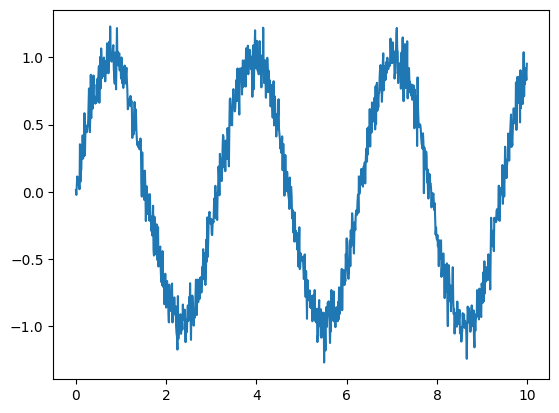

In [10]:
plt.plot(gen_values(2)[0], gen_values(2)[1])

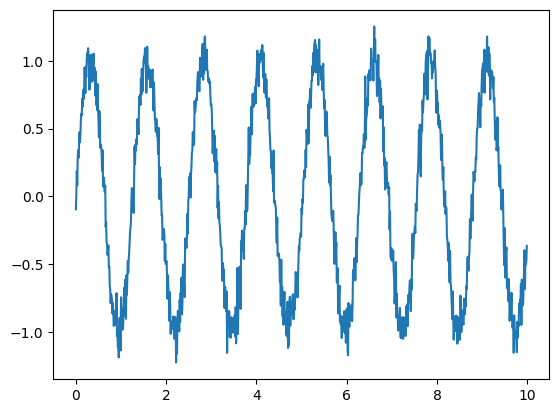

In [27]:
plt.plot(gen_values(5)[0], gen_values(5)[1])

In [35]:
loss_relu = []

In [36]:
for k in range(2,500,1):
  relu_model = relu_mlp(4,4)
  criterion = nn.MSELoss()
  optimizer = optim.Adam(relu_model.parameters(), lr=0.0001)
  num_epochs = 10
  X = gen_values(k)[0].reshape(-1,1)
  y = gen_values(k)[1]
  for e in range(num_epochs):
    y_pred_train = relu_model(torch.from_numpy(X.astype('float32'))).squeeze()
    loss = criterion(y_pred_train, torch.from_numpy(y.astype('float32'))) # loss is a tensor which stores the current value of train loss
    #relu_psnr.append(20 * np.log10(1.0 / np.sqrt(loss.item())))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_now = loss.item()

  loss_relu.append(loss_now)

In [38]:
len(loss_relu)

498

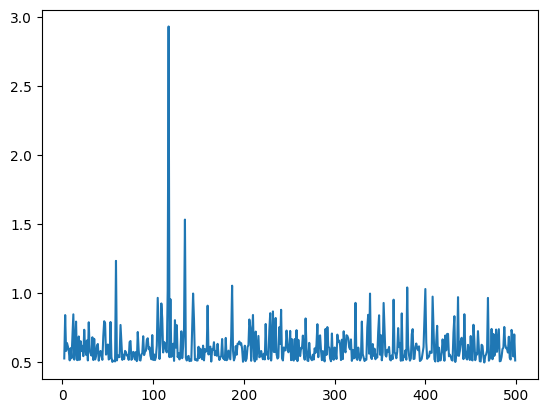

In [37]:
plt.plot(range(2,500,1), loss_relu)

In [40]:
loss_siren = []

In [42]:
for k in range(2,500,1):
  siren_model = siren_mlp(4,4, 30)
  criterion = nn.MSELoss()
  optimizer = optim.Adam(siren_model.parameters(), lr=0.0001)
  num_epochs = 10
  X = gen_values(k)[0].reshape(-1,1)
  y = gen_values(k)[1]
  for e in range(num_epochs):
    y_pred_train = siren_model(torch.from_numpy(X.astype('float32'))).squeeze()
    loss = criterion(y_pred_train, torch.from_numpy(y.astype('float32'))) # loss is a tensor which stores the current value of train loss
    #relu_psnr.append(20 * np.log10(1.0 / np.sqrt(loss.item())))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_now = loss.item()

  loss_siren.append(loss_now)

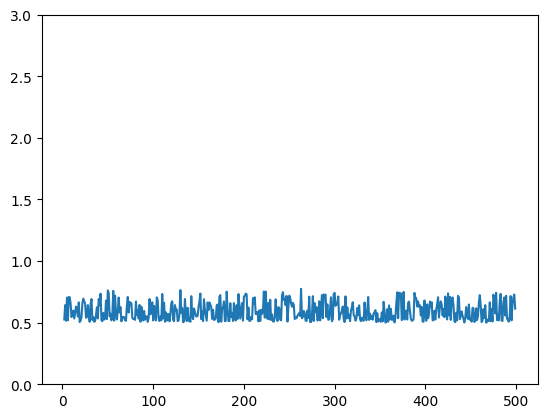

In [44]:
plt.plot(range(2,500,1), loss_siren)
plt.ylim(0,3)
plt.show()